# Test Zone: Graphs, Representations, MolView and MolecularGraph

## Description:
We want to see whether we can generate a graph representation for fragments interacting noncovalently. This is not trivial, since now the 3D information need to be included in the graph, and a simple SMILE rep doesnt do the job.
For this, we can try few things but first I want to check if the representations and graphs functions in NONCOVToolbox work as planned. Then we proceed from there.

In [3]:
# Get the NONCOVToolbox library and print header
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.cluster import KMeans
import pathlib as Path
import importlib

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox, NONCOVHeader

noncov = NONCOVToolbox()

NONCOVHeader.print_header()

from noncov import MolView
from noncov import OrcaAnalysis
from noncov import MolecularGraph

# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore printing
def enablePrint():
    sys.stdout = sys.__stdout__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Get work directory and scratch folder for the output data
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')

scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')

molrep_dir = os.path.join(scratch_dir, 'MolRep')
print(f'Current MolRep directory is: {molrep_dir}')

scratch_dir = OrcaAnalysis().convert_path(scratch_dir)

Current work directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scripts
Current scratch directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch
Current MolRep directory is: D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch\MolRep
Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch


In [23]:
molecule = os.path.join(molrep_dir, 'tests\KLaL_cation_pi_RCCE.xyz')
molecule = OrcaAnalysis().convert_path(molecule)
molecule

Normalized path using os.path: D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/MolRep/tests/KLaL_cation_pi_RCCE.xyz


<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:1: SyntaxWarning: invalid escape sequence '\K'
C:\Users\Ettore Bartalucci\AppData\Local\Temp\ipykernel_26868\1822798315.py:1: SyntaxWarning: invalid escape sequence '\K'
  molecule = os.path.join(molrep_dir, 'tests\KLaL_cation_pi_RCCE.xyz')


'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/MolRep/tests/KLaL_cation_pi_RCCE.xyz'

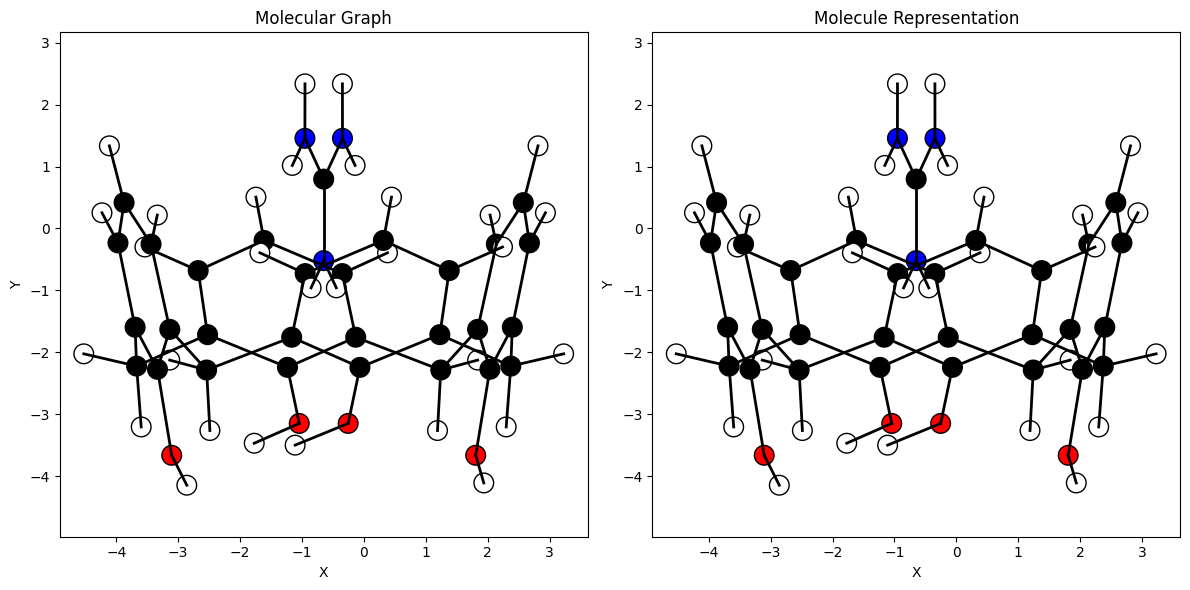

In [32]:
mol = MolRep(molecule)
mol.plot()

In [44]:
threshold = 1.52

threshold_gua = 2

mol_graph = MolecularGraph()

# Parse the XYZ file
atom_types, coordinates = mol_graph.parse_xyz(molecule)

# Calculate pairwise distances
distances = mol_graph.calculate_distances(coordinates)

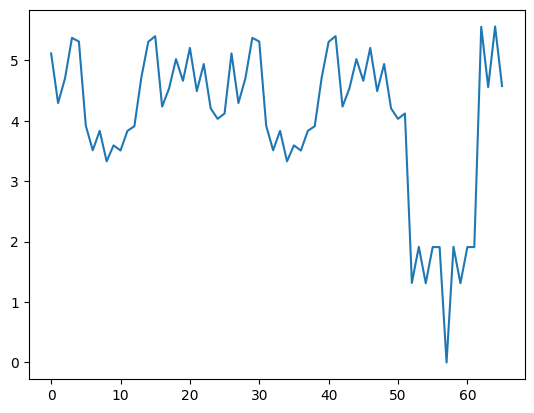

In [53]:
for i in

In [49]:
atom_types[1]

'O'

In [ ]:
# Detect covalent bonds
covalent_bonds = mol_graph.detect_bonds(atom_types, distances)

# Detect non-covalent interactions
noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)

# Build the molecular graph
mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)

# Visualize the molecular graph
#mol_graph.draw()

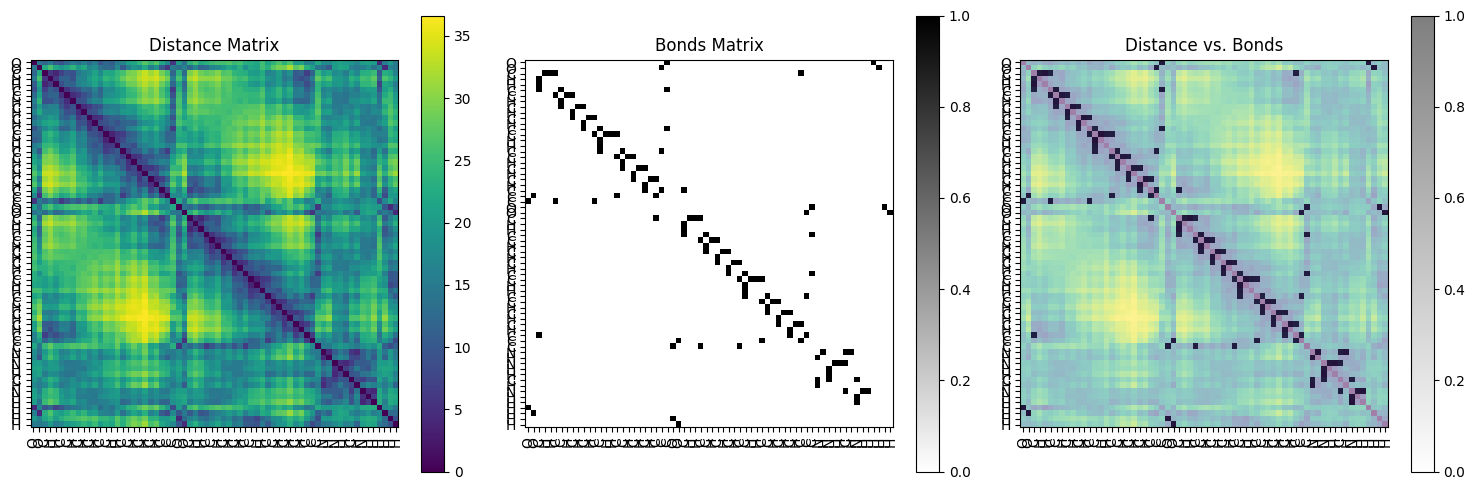

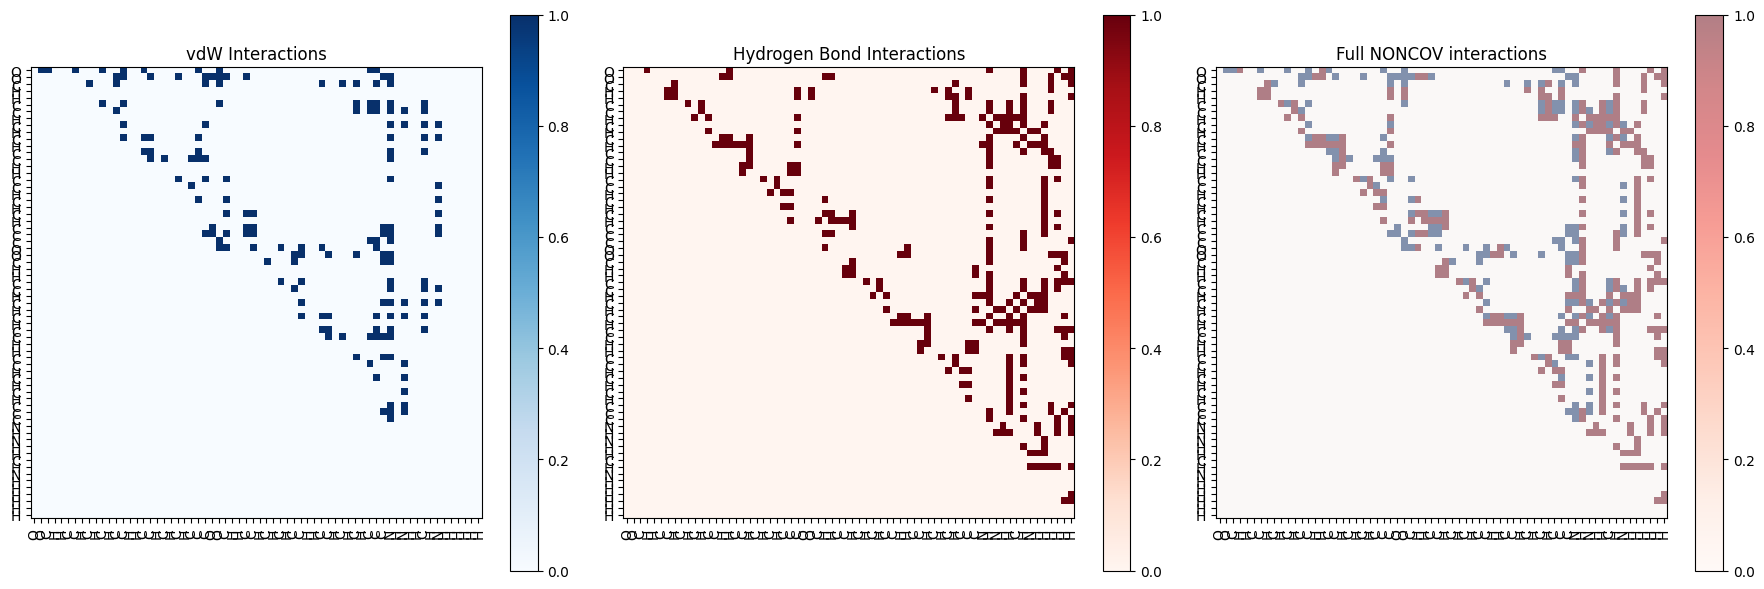

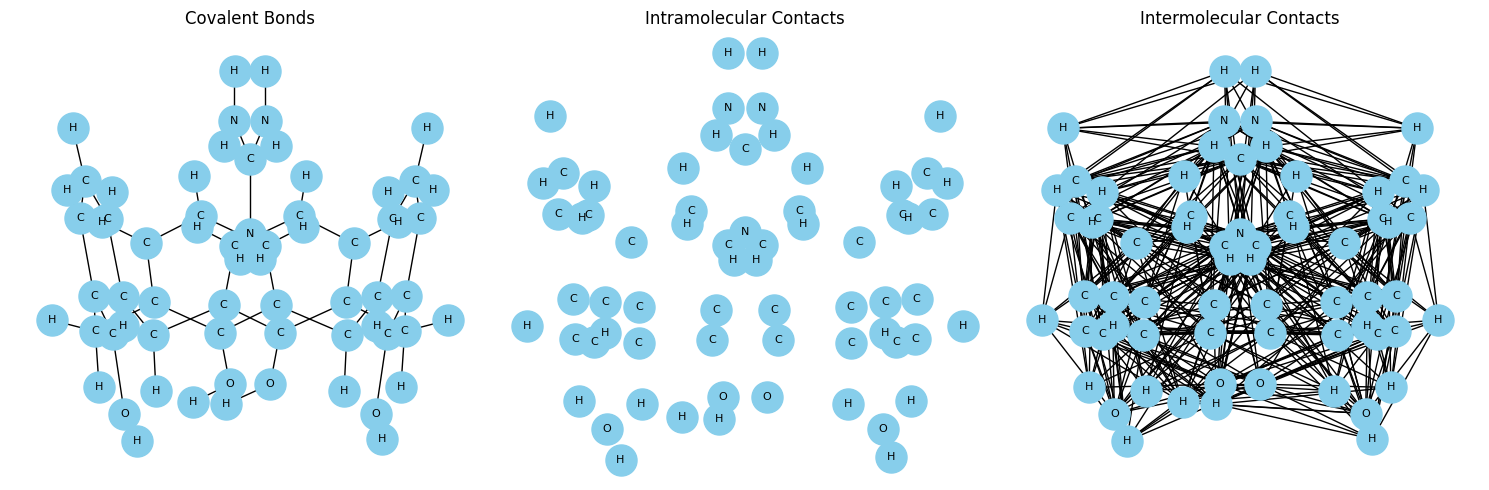

In [43]:
# Plots 
mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

# Build different graphs
covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

# Draw subplots while preserving atom positions
mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)

## MolRep

In [31]:
import os
import sys
import numpy as np
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

class MolRep:
    def __init__(self, xyz_file):
        """
        Initialize the MolRep class with an XYZ file.
        
        Parameters:
        xyz_file (str): Path to the XYZ file containing the molecular structure.
        """
        self.xyz_file = xyz_file
        self.atoms = []
        self.positions = []
        self.bonds = []
        self._parse_xyz()
        self._create_bonds()

    def _parse_xyz(self):
        """
        Internal method to parse the XYZ file and extract atoms and their positions.
        """
        with open(self.xyz_file, 'r') as f:
            lines = f.readlines()
            for line in lines[2:]:  # Skip the first two lines (header)
                parts = line.split()
                atom = parts[0]
                x, y, z = map(float, parts[1:4])
                self.atoms.append(atom)
                self.positions.append((x, y, z))
        
        self.positions = np.array(self.positions)
        
    def _create_bonds(self):
        """
        Internal method to create bonds based on simple distance criteria.
        """
        n_atoms = len(self.atoms)
        for i in range(n_atoms):
            for j in range(i+1, n_atoms):
                distance = np.linalg.norm(self.positions[i] - self.positions[j])
                # Simple bond criterion (you can adjust this threshold)
                if distance < 1.52:  # Consider atoms bonded if within 1.6 Å
                    self.bonds.append((i, j))

    def plot(self):
        """
        Plots the molecule in two subplots:
        - Left: Licorice representation of the molecule.
        - Right: Highlighted nodes and edges.
        """
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        color_map = {'H': 'white', 'C': 'black', 'O': 'red', 'N': 'blue', 'S': 'yellow'}

        colors = [color_map.get(atom, 'gray') for atom in self.atoms]

        axes[0].scatter(self.positions[:, 0], self.positions[:, 1], s=200, c=colors, edgecolor='k')
        for bond in self.bonds:
            i, j = bond
            axes[0].plot([self.positions[i, 0], self.positions[j, 0]],
                         [self.positions[i, 1], self.positions[j, 1]], 'k-', lw=2)
        axes[0].set_title('Molecular Graph')
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Y')
        axes[0].axis('equal')

        axes[1].scatter(self.positions[:, 0], self.positions[:, 1], s=200, c=colors, edgecolor='k')
        for bond in self.bonds:
            i, j = bond
            axes[1].plot([self.positions[i, 0], self.positions[j, 0]],
                         [self.positions[i, 1], self.positions[j, 1]], 'k-', lw=2)
       
        axes[1].set_title('Molecule Representation')
        axes[1].set_xlabel('X')
        axes[1].set_ylabel('Y')
        axes[1].axis('equal')

        plt.tight_layout()
        plt.show()

## MolView

In [34]:
class MolView(NONCOVToolbox):
    """
    Molecular visualization class
    """
    def __init__(self):
        super().__init__()

    def radiusovaloid(self, sxx, syy, szz, alpha, beta, gamma, theta, phi):
        '''
        to check, taken from TensorView source code ()
        '''
        r_ov = (sxx * (np.sin(gamma) * np.sin(alpha - phi) * np.sin(theta) + np.cos(gamma) * (np.cos(theta) * np.sin(beta) - np.cos(beta) * np.cos(alpha - phi) * np.sin(theta))) ** 2
            + syy * (np.cos(theta) * np.sin(beta) * np.sin(gamma) - (np.cos(beta) * np.cos(alpha - phi) * np.sin(gamma) + np.cos(gamma) * np.sin(alpha - phi) * np.sin(theta))) ** 2
            + szz * (np.cos(beta) * np.cos(theta) + np.cos(alpha - phi) * np.sin(beta) * np.sin(theta)) ** 2)
        
        print(f'Radius of ovaloid representation is: {r_ov}')
        
        return r_ov
    
    def plot_tensor_shielding(S_dia, S_para, S_tot, nuclear_identities, 
                            displacement_steps_distance, min_distance_value, max_distance_value, 
                            scratch_dir, iteration):
        """
        Plots tensor shielding values (diamagnetic, paramagnetic, and total) for each nucleus.

        :param S_dia: List of dictionaries with diamagnetic tensor components.
        :param S_para: List of dictionaries with paramagnetic tensor components.
        :param S_tot: List of dictionaries with total tensor components.
        :param nuclear_identities_2: List of nuclear identity strings.
        :param displacement_steps_distance: List of displacement steps.
        :param min_distance_value: Minimum distance value for shading the NONCOV effective region.
        :param max_distance_value: Maximum distance value for shading the NONCOV effective region.
        :param scratch_dir: Directory to save the plots.
        :param iteration: Current iteration number (used for filename).
        """
        # Create a folder to save the tensor plots as PDFs and JPEGs if it doesn't exist
        pas_tensors_figures_folder = os.path.join(scratch_dir, 'OrcaAnalysis/tensor_plots')
        os.makedirs(pas_tensors_figures_folder, exist_ok=True)

        # Loop over each nucleus identity and plot its tensor shielding values
        for nucleus_list in nuclear_identities:
            for nucleus_key in nucleus_list:
                if isinstance(nucleus_key, list):
                    nucleus_key = "_".join(map(str, nucleus_key))
                    
                # Extract individual contributions to shielding values for the current nucleus from each dictionary
                nucleus_values_S_dia = [d.get(nucleus_key, [])[0] for d in S_dia]
                nucleus_values_S_para = [d.get(nucleus_key, [])[0] for d in S_para]
                nucleus_values_S_tot = [d.get(nucleus_key, [])[0] for d in S_tot]

                # Split the nucleus_key into a tuple (nucleus number, element)
                nucleus = tuple(nucleus_key.split())

                # Plot the shielding values for the current nucleus
                plt.plot(nucleus_values_S_dia, marker='o', linestyle='-', color='darkblue', label=r'$\sigma$_dia_11')
                plt.plot(nucleus_values_S_para, marker='o', linestyle='-', color='orangered', label=r'$\sigma$_para_11')
                plt.plot(nucleus_values_S_tot, marker='o', linestyle='-', color='gold', label=r'$\sigma$_tot_11')

                # Highlight the NONCOV effective region (optional, can be commented out if not needed)
                if min_distance_value is not None and max_distance_value is not None:
                    plt.axvspan(min_distance_value, max_distance_value, alpha=0.2, color='grey', label='NONCOV \n effective region')
                
                # Set labels and title
                plt.xlabel('Displacement from initial geometry / Å')
                plt.ylabel('Shielding / ppm')
                plt.title(f'Nucleus {nucleus[1]} {nucleus[2]} - Iteration {iteration}')
                
                # Display legend
                plt.legend(loc='best')
                
        # Save the plot as a PDF in the output folder
        pdf_filename = os.path.join(pas_tensors_figures_folder, f'nucleus_{nucleus[1]}_iteration_{iteration}.pdf')
        plt.savefig(pdf_filename, bbox_inches='tight')

        # Save the plot as a JPEG in the output folder
        jpg_filename = os.path.join(pas_tensors_figures_folder, f'nucleus_{nucleus[1]}_iteration_{iteration}.jpg')
        plt.savefig(jpg_filename, bbox_inches='tight')
        
        # Show the plot (optional, can be commented out if you don't want to display the plots)
        #plt.show()

        # Clear the current figure for the next iteration
        plt.clf()

    def euler_angles_to_rotation_matrix(alpha, beta, gamma):
        """
        Convert Euler angles to rotation matrix.
        :param alpha: Rotation angle around the Z-axis
        :param beta: Rotation angle around the X-axis
        :param gamma: Rotation angle around the Z-axis
        :return: Rotation matrix
        """
        r = R.from_euler('zyz', [alpha, beta, gamma], degrees=True)
        return r.as_matrix()

    def plot_3D_tensor(tensor, label, color, ax):
        """
        Plot a 3D tensor (as ellipsoid).
        :param tensor: The tensor to plot
        :param label: Label for the tensor
        :param color: Color of the tensor
        :param ax: The axes to plot on
        """
        # Compute the ellipsoid coordinates - replace here with radius ovaloid
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))

        # Scale ellipsoid by the tensor eigenvalues
        eigenvalues, eigenvectors = np.linalg.eig(tensor)
        ellipsoid = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), np.array([x.flatten(), y.flatten(), z.flatten()])))
        x, y, z = ellipsoid.reshape((3, *x.shape))

        ax.plot_surface(x, y, z, color=color, alpha=0.5)
        ax.set_title(label)

    def plot_tensor_principal_axes(tensor_pas, tensor, color):
        """
        Plot the principal axes of a tensor.
        :param ax: The axes to plot on
        :param tensor: The tensor whose axes to plot
        :param color: Color of the axes
        """
        origin = np.array([0, 0, 0])
        eigenvalues, eigenvectors = np.linalg.eig(tensor)
        
        for i in range(3):
            tensor_pas.quiver(*origin, *eigenvectors[:, i], length=eigenvalues[i], color=color, label=f'Axis {i+1}')

        tensor_pas.set_xlim([-1, 1])
        tensor_pas.set_ylim([-1, 1])
        tensor_pas.set_zlim([-1, 1])
        tensor_pas.set_xlabel('X')
        tensor_pas.set_ylabel('Y')
        tensor_pas.set_zlabel('Z')

    def plot_3D_tensors_and_axes(tensor_pas, alpha, beta, gamma):
        """
        Plot the original tensor, rotated tensor, and their axes.
        :param tensor_pas: Diagonal tensor in PAS
        :param alpha: Rotation angle around the Z-axis (degrees)
        :param beta: Rotation angle around the X-axis (degrees)
        :param gamma: Rotation angle around the Z-axis (degrees)
        """
        # Compute the rotation matrix from Euler angles
        rotation_matrix = MolView.euler_angles_to_rotation_matrix(alpha, beta, gamma)
        
        # Compute the rotated tensor
        tensor_rotated = rotation_matrix @ tensor_pas @ np.linalg.inv(rotation_matrix)

        fig = plt.figure(figsize=(16, 12))

        # Original Tensor Plot
        ax1 = fig.add_subplot(221, projection='3d')
        MolView.plot_3D_tensor(tensor_pas, 'Original Tensor', 'blue', ax1)
        
        # Rotated Tensor Plot
        ax2 = fig.add_subplot(222, projection='3d')
        MolView.plot_3D_tensor(tensor_rotated, 'Rotated Tensor', 'red', ax2)

        # Original Tensor Axes
        ax3 = fig.add_subplot(223, projection='3d')
        MolView.plot_tensor_principal_axes(ax3, tensor_pas, 'blue')
        ax3.set_title('Original Tensor Axes')

        # Rotated Tensor Axes
        ax4 = fig.add_subplot(224, projection='3d')
        MolView.plot_tensor_principal_axes(ax4, tensor_rotated, 'red')
        ax4.set_title('Rotated Tensor Axes')

        plt.tight_layout()
        plt.show()



## MolecularGraph

In [41]:
class MolecularGraph:
    def __init__(self):
        super().__init__()
        self.graph = nx.Graph()

    def add_atom(self, atom_index, atom_type, coordinate):
        self.graph.add_node(atom_index, atom_type=atom_type, coordinate=coordinate[:3])
    
    def add_bond(self, atom1_index, atom2_index, bond_type="covalent"):
        self.graph.add_edge(atom1_index, atom2_index, bond_type=bond_type)

    def draw(self, mol_fragment=None):
        pos = nx.spring_layout(self.graph)  
        labels = nx.get_node_attributes(self.graph, 'atom_type')
        bond_types = nx.get_edge_attributes(self.graph, 'bond_type')
        
        colors = ['red', 'blue', 'orange', 'purple', 'darkseagreen', 'gold', ]
        
        node_colors = []
        
        edge_colors = ["gold" if bond == "noncovalent" else "black" for bond in bond_types.values()]

        edge_x = []
        edge_y = []
        
        for edge in self.graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=2, color='gold'),
            hoverinfo='none',
            mode='lines'
        )

        node_x = []
        node_y = []
        node_text = [labels[node] for node in self.graph.nodes()]

        for node in self.graph.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            hoverinfo='text',
            text=node_text,
            marker=dict(
                showscale=False,
                color='skyblue',
                size=20,
                line_width=2)
        )

        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title='<br>Molecular Graph',
                            titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20,l=5,r=5,t=40),
                            annotations=[dict(
                                text="Molecule from XYZ file",
                                showarrow=False,
                                xref="paper", yref="paper",
                                x=0.005, y=-0.002)],
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                        )

        fig.show()

    def parse_xyz(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()[2:]  # skip the first two lines (atom count and comment)
            coordinates = []
            atom_identities = [] # this is the one storing atom identity info, need to append it at a later step
            for line in lines:
                atom_data = line.split()
                atom_identity = atom_data[0] 
                coord = [float(atom_data[1]), float(atom_data[2]), float(atom_data[3])]
                coordinates.append(coord)
                atom_identities.append(atom_identity)
            coordinates = np.array(coordinates)
            atom_identities = np.array(atom_identities)
            return atom_identities, coordinates

    # clear
    def calculate_distances(self, coordinates):
        num_atoms = len(coordinates)
        distances = np.zeros((num_atoms, num_atoms)) # make a 2x2 matrix
        for i in range(num_atoms):
            for j in range(i + 1, num_atoms):
                distances[i, j] = distances[j, i] = np.linalg.norm(coordinates[i] - coordinates[j])
        return distances
    
    # clear
    def plot_distance_matrix(self, distances, atom_labels):
        distance_matrix = squareform(pdist(distances, 'euclidean'))
        plt.imshow(distance_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Distance')
        plt.title('Matrix of 2D distances')
        plt.xticks(ticks=np.arange(len(atom_labels)), labels=atom_labels)
        plt.yticks(ticks=np.arange(len(atom_labels)), labels=atom_labels)
        plt.show()

    # clear
    def plot_bond_matrix(self, bonds_matrix, atom_labels):
        plt.imshow(bonds_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Bool')
        plt.title('Matrix of 2D Bonds')
        plt.xticks(ticks=np.arange(len(atom_labels)), labels=atom_labels)
        plt.yticks(ticks=np.arange(len(atom_labels)), labels=atom_labels)
        plt.show()

    # clear
    def plot_bond_dist_matrix(self, bonds_matrix, distances, atom_labels):
        distance_matrix = squareform(pdist(distances, 'euclidean'))

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        im1 = axes[0].imshow(distance_matrix, cmap='viridis', interpolation='nearest')
        axes[0].set_title('Distance Matrix')
        fig.colorbar(im1, ax=axes[0])
        axes[0].set_xticks(np.arange(len(atom_labels)))
        axes[0].set_xticklabels(atom_labels, rotation=90)
        axes[0].set_yticks(np.arange(len(atom_labels)))
        axes[0].set_yticklabels(atom_labels)

        im2 = axes[1].imshow(bonds_matrix, cmap='gray_r', interpolation='nearest')
        axes[1].set_title('Bonds Matrix')
        fig.colorbar(im2, ax=axes[1])
        axes[1].set_xticks(np.arange(len(atom_labels)))
        axes[1].set_xticklabels(atom_labels, rotation=90)
        axes[1].set_yticks(np.arange(len(atom_labels)))
        axes[1].set_yticklabels(atom_labels)

        axes[2].imshow(distance_matrix, cmap='viridis', interpolation='nearest')
        im3 = axes[2].imshow(bonds_matrix, cmap='gray_r', interpolation='nearest', alpha=0.5)
        axes[2].set_title('Distance vs. Bonds')
        fig.colorbar(im3, ax=axes[2])
        axes[2].set_xticks(np.arange(len(atom_labels)))
        axes[2].set_xticklabels(atom_labels, rotation=90)
        axes[2].set_yticks(np.arange(len(atom_labels)))
        axes[2].set_yticklabels(atom_labels)

        plt.tight_layout()
        plt.show()

    # clear / need new logic
    def detect_bonds(self, atom_types, distances):
        covalent_radii = {'H': 0.31, 'C': 0.76, 'N': 0.71, 'O': 0.66}  # Extend as needed
        bond_matrix = np.zeros(distances.shape, dtype=bool)
        for i, atom1 in enumerate(atom_types):
            for j, atom2 in enumerate(atom_types):
                if i < j:
                    max_bond_dist = covalent_radii[atom1] + covalent_radii[atom2] + 0.4  # tolerance
                    if distances[i, j] < max_bond_dist:
                        bond_matrix[i, j] = bond_matrix[j, i] = True
        return bond_matrix

    # clear / need new logic
    def detect_noncovalent_interactions(self, atom_types, distances):
        noncovalent_interactions = []
        for i, atom1 in enumerate(atom_types):
            for j, atom2 in enumerate(atom_types):
                if i < j:
                    if distances[i, j] > 2.5 and distances[i, j] < 4.0:  # Rough range for non-covalent interaction
                        interaction_type = "hydrogen_bond" if "H" in [atom1, atom2] else "vdW"
                        noncovalent_interactions.append((i, j, interaction_type))
        return noncovalent_interactions
    
    # clear / need new logic
    def plot_noncov_distance_map(self, noncovalent_interactions, atom_labels):
        # Determine the matrix size
        n = max(max(i[0], i[1]) for i in noncovalent_interactions) + 1

        interaction_matrix = np.zeros((n, n), dtype=int)
        vdw_matrix = np.zeros((n, n), dtype=bool)
        hb_matrix = np.zeros((n, n), dtype=bool)

        for i, j, interaction in noncovalent_interactions:
            interaction_matrix[i, j] = 1  # 1 for any interaction
            if interaction == 'vdW':
                vdw_matrix[i, j] = True
            elif interaction == 'hydrogen_bond':
                hb_matrix[i, j] = True

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        im1 = axes[0].imshow(vdw_matrix, cmap='Blues', interpolation='nearest')
        axes[0].set_title('vdW Interactions')
        fig.colorbar(im1, ax=axes[0])
        axes[0].set_xticks(np.arange(len(atom_labels)))
        axes[0].set_xticklabels(atom_labels, rotation=90)
        axes[0].set_yticks(np.arange(len(atom_labels)))
        axes[0].set_yticklabels(atom_labels)

        im2 = axes[1].imshow(hb_matrix, cmap='Reds', interpolation='nearest')
        axes[1].set_title('Hydrogen Bond Interactions')
        fig.colorbar(im2, ax=axes[1])
        axes[1].set_xticks(np.arange(len(atom_labels)))
        axes[1].set_xticklabels(atom_labels, rotation=90)
        axes[1].set_yticks(np.arange(len(atom_labels)))
        axes[1].set_yticklabels(atom_labels)

        axes[2].imshow(vdw_matrix, cmap='Blues', interpolation='nearest')
        im3 = axes[2].imshow(hb_matrix, cmap='Reds', interpolation='nearest', alpha=0.5)
        axes[2].set_title('Full NONCOV interactions')
        fig.colorbar(im3, ax=axes[2])
        axes[2].set_xticks(np.arange(len(atom_labels)))
        axes[2].set_xticklabels(atom_labels, rotation=90)
        axes[2].set_yticks(np.arange(len(atom_labels)))
        axes[2].set_yticklabels(atom_labels)

        plt.tight_layout()
        plt.show()

    def build_molecular_graph(self, atom_types, coordinates, covalent_bonds, noncovalent_interactions):
        mol_graph = MolecularGraph()

        # Add atoms to the graph
        for i, (atom_type, position) in enumerate(zip(atom_types, coordinates)):
            mol_graph.add_atom(i, atom_type, position)

        # Add covalent bonds
        for i in range(len(atom_types)):
            for j in range(i + 1, len(atom_types)):
                if covalent_bonds[i, j]:
                    mol_graph.add_bond(i, j, bond_type="covalent")

        # Add non-covalent interactions
        for i, j, interaction_type in noncovalent_interactions:
            mol_graph.add_bond(i, j, bond_type=interaction_type)

        return mol_graph
    
    def draw_subplots(self, covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Draw Covalent Bonds Graph
        self._draw_graph(covalent_bonds_graph, coordinates, ax=axes[0], title='Covalent Bonds')

        # Draw Intramolecular Contacts Graph
        self._draw_graph(intramolecular_graph, coordinates, ax=axes[1], title='Intramolecular Contacts')

        # Draw Intermolecular Contacts Graph
        self._draw_graph(intermolecular_graph, coordinates, ax=axes[2], title='Intermolecular Contacts')
        
        plt.tight_layout()
        plt.show()

    def _draw_graph(self, graph, coordinates, ax, title):
        # Use the original coordinates as the positions for the nodes
        pos = {i: (coordinates[i][0], coordinates[i][1]) for i in graph.nodes()}  # X, Y coordinates

        labels = nx.get_node_attributes(graph, 'atom_type')
        bond_types = nx.get_edge_attributes(graph, 'bond_type')
        edge_colors = ["blue" if bond == "noncovalent" else "black" for bond in bond_types.values()]

        nx.draw(graph, pos, ax=ax, labels=labels, with_labels=True, node_size=500, node_color="skyblue", edge_color=edge_colors, font_size=8)
        ax.set_title(title)

    def build_covalent_bonds_graph(self, atom_types, coordinates, covalent_bonds):
        graph = nx.Graph()
        for i, (atom_type, position) in enumerate(zip(atom_types, coordinates)):
            graph.add_node(i, atom_type=atom_type, coordinate=position)
        for i in range(len(atom_types)):
            for j in range(i + 1, len(atom_types)):
                if covalent_bonds[i, j]:
                    graph.add_edge(i, j, bond_type="covalent")
        return graph

    def build_intramolecular_graph(self, atom_types, coordinates, covalent_bonds, noncovalent_interactions):
        graph = nx.Graph()
        for i, (atom_type, position) in enumerate(zip(atom_types, coordinates)):
            graph.add_node(i, atom_type=atom_type, coordinate=position)
        for i, j, interaction_type in noncovalent_interactions:
            if covalent_bonds[i, j]:  # Intramolecular if there's a covalent bond
                graph.add_edge(i, j, bond_type="intramolecular")
        return graph

    def build_intermolecular_graph(self, atom_types, coordinates, noncovalent_interactions):
        graph = nx.Graph()
        for i, (atom_type, position) in enumerate(zip(atom_types, coordinates)):
            graph.add_node(i, atom_type=atom_type, coordinate=position)
        for i, j, interaction_type in noncovalent_interactions:
            if interaction_type != "intramolecular":  # Intermolecular if not intramolecular
                graph.add_edge(i, j, bond_type="intermolecular")
        return graph